In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import noisereduce as nr
import pywt
import warnings
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import jiwer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import jiwer

warnings.filterwarnings('ignore')


c:\Users\gabry\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAMPLE_RATE = 16000
N_MFCC = 13
N_MELS = 22
WINDOW = int(SAMPLE_RATE * 0.01)
HOP = int(SAMPLE_RATE * 0.005)
COMMANDS = ["baca", "berhenti", "foto", "halo", "info", "kembali", "ulang"]


In [3]:
def load_audio(file_path, sr=SAMPLE_RATE):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio / np.max(np.abs(audio))

# def reduce_noise(audio):
#     return nr.reduce_noise(y=audio, sr=SAMPLE_RATE)

# def preprocess_audio(file_path):
#     audio = load_audio(file_path)
#     return reduce_noise(audio)

def wavelet_transform(signal):
    wp = pywt.WaveletPacket(signal, wavelet='db4', mode='symmetric', maxlevel=3)
    return np.concatenate([n.data for n in wp.get_level(3, 'freq')])

def extract_mfcc(signal):
    return librosa.feature.mfcc(
        y=wavelet_transform(signal),
        sr=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        n_mels=N_MELS,
        n_fft=WINDOW,
        hop_length=HOP
    ).T


In [4]:
def load_dataset(directory, commands):
    data = []
    for label in commands:
        folder = os.path.join(directory, label)
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                data.append((os.path.join(folder, file), label))
    return pd.DataFrame(data, columns=["speech", "label"])


In [5]:
def extract_features(df):
    print("Preprocessing and extracting features...")
    features = Parallel(n_jobs=-1)(
        delayed(lambda path: extract_mfcc(load_audio(path)))(fp)
        for fp in tqdm(df['speech'], desc="Extracting")
    )
    df['mfcc'] = features
    return df


In [6]:
def encode_and_pad(df_train, df_valid):
    le = LabelEncoder()
    df_train['label_encoded'] = le.fit_transform(df_train['label'])
    df_valid['label_encoded'] = le.transform(df_valid['label'])

    all_mfcc = df_train['mfcc'].tolist() + df_valid['mfcc'].tolist()
    max_len = max(len(x) for x in all_mfcc)

    X_train = pad_sequences(df_train['mfcc'], maxlen=max_len, padding='post', dtype='float32')
    X_valid = pad_sequences(df_valid['mfcc'], maxlen=max_len, padding='post', dtype='float32')

    y_train = to_categorical(df_train['label_encoded'])
    y_valid = to_categorical(df_valid['label_encoded'])

    return X_train, y_train, X_valid, y_valid, le


In [7]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        LSTM(128, return_sequences=True),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
def train_model(model, X_train, y_train, X_valid, y_valid, batch_size=32, epochs=100):
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    return model, history


In [9]:
def evaluate_model(model, X_valid, y_valid, label_encoder):
    # Mulai timer
    start = time.time()
    
    # Predict
    y_pred_probs = model.predict(X_valid)
    end = time.time()
    
    # Konversi ke kelas
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_valid, axis=1)
    
    # Classification Report
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
    
    # RTF (Real Time Factor) - asumsi 16 kHz
    audio_duration_total = (X_valid.shape[0] * X_valid.shape[1]) / 16000
    rtf = (end - start) / audio_duration_total
    print(f"RTF (Real Time Factor): {rtf:.4f}")
    
    # Precision, Recall, F1 Score (weighted)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    return {
        'RTF': rtf,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'y_true': y_true,
        'y_pred': y_pred_classes
    }


In [10]:
# Load datasets
df_train = load_dataset("dataaug/train", COMMANDS)
df_valid = load_dataset("dataaug/validation", COMMANDS)

In [12]:
df_train['label'].value_counts()

label
kembali     981
ulang       966
baca        963
foto        963
berhenti    960
halo        957
info        957
Name: count, dtype: int64

In [11]:
df_valid['label'].value_counts()

label
kembali     141
baca        138
berhenti    138
foto        138
info        138
ulang       138
halo        137
Name: count, dtype: int64

In [13]:
# Preprocessing + Feature extraction
df_train = extract_features(df_train)
df_valid = extract_features(df_valid)


Preprocessing and extracting features...


Extracting: 100%|██████████| 6747/6747 [00:13<00:00, 511.20it/s]


Preprocessing and extracting features...


Extracting: 100%|██████████| 968/968 [00:01<00:00, 907.32it/s] 


In [14]:
# Encode & pad
X_train, y_train, X_valid, y_valid, le = encode_and_pad(df_train, df_valid)

In [15]:
# Build model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=y_train.shape[1])

In [16]:
# Train model
model, history = train_model(model, X_train, y_train, X_valid, y_valid)

Epoch 1/100
211/211 [==============================] - 52s 185ms/step - loss: 1.9306 - accuracy: 0.1684 - val_loss: 1.8303 - val_accuracy: 0.2541
Epoch 2/100
211/211 [==============================] - 35s 168ms/step - loss: 1.6243 - accuracy: 0.2780 - val_loss: 1.4375 - val_accuracy: 0.3595
Epoch 3/100
211/211 [==============================] - 36s 170ms/step - loss: 1.4008 - accuracy: 0.3928 - val_loss: 1.1717 - val_accuracy: 0.4773
Epoch 4/100
211/211 [==============================] - 35s 168ms/step - loss: 1.1798 - accuracy: 0.4990 - val_loss: 0.9866 - val_accuracy: 0.5610
Epoch 5/100
211/211 [==============================] - 36s 171ms/step - loss: 1.0260 - accuracy: 0.5641 - val_loss: 0.8252 - val_accuracy: 0.6612
Epoch 6/100
211/211 [==============================] - 37s 175ms/step - loss: 0.8893 - accuracy: 0.6352 - val_loss: 0.6529 - val_accuracy: 0.7242
Epoch 7/100
211/211 [==============================] - 38s 182ms/step - loss: 0.7485 - accuracy: 0.7160 - val_loss: 0.5571 -

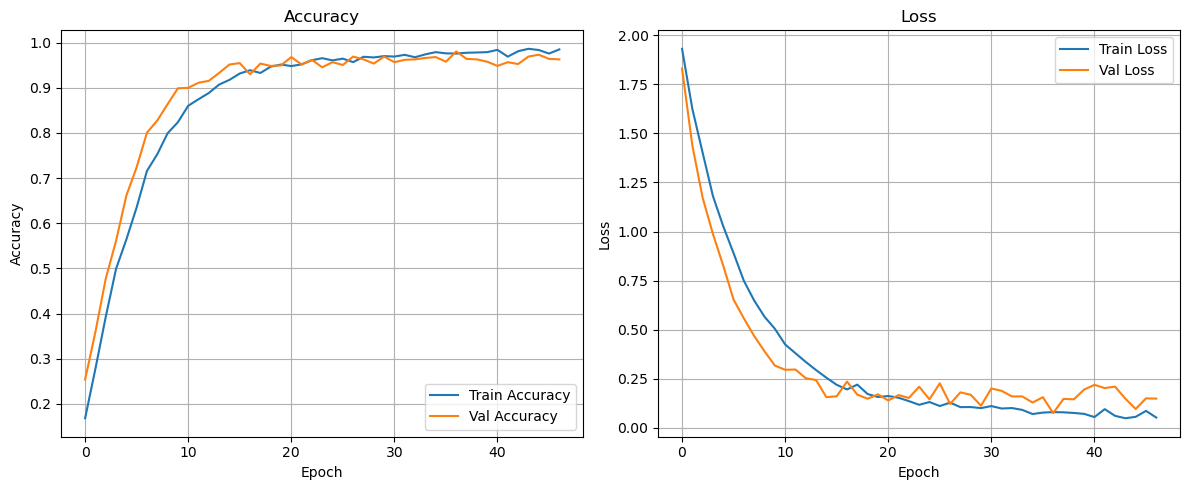

In [17]:
# Grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
# plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafik loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
# plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# val_accuracy terbaik
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  
print(f"Val accuracy terbaik: {best_val_acc:.4f} pada epoch ke-{best_epoch}")

In [18]:
#Evaluasi
metrics = evaluate_model(model, X_valid, y_valid, le)


31/31 [==============================] - 6s 87ms/step

=== Classification Report ===
              precision    recall  f1-score   support

        baca       1.00      0.97      0.99       138
    berhenti       0.97      0.98      0.97       138
        foto       0.97      1.00      0.99       138
        halo       1.00      0.96      0.98       137
        info       1.00      1.00      1.00       138
     kembali       0.94      0.99      0.96       141
       ulang       0.99      0.96      0.97       138

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968

RTF (Real Time Factor): 0.1268
Precision (weighted): 0.9809
Recall (weighted): 0.9804
F1 Score (weighted): 0.9804


In [19]:
model.save('model/mymodelf.h5')